In [122]:
import pandas as pd
from dataprep.eda import plot, plot_correlation
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Read Data

In [2]:
patient = pd.read_csv("mimic/PATIENTS.csv")
admission = pd.read_csv("mimic/ADMISSIONS.csv")
diagnoses_d = pd.read_csv("mimic/D_ICD_DIAGNOSES.csv")
diagnoses = pd.read_csv("mimic/DIAGNOSES_ICD.csv")
icu = pd.read_csv("mimic/ICUSTAYS.csv")
# prescriptions = pd.read_csv("mimic/PRESCRIPTIONS.csv")
# procedure_d = pd.read_csv('mimic/D_ICD_PROCEDURES.csv')
# procedure = pd.read_csv('mimic/PROCEDURES_ICD.csv')
# procedure = procedure.merge(procedure_d, on='ICD9_CODE')
services = pd.read_csv('mimic/SERVICES.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# Assign diagnoses groups according to ICD9_CODE
def assign_category(icd9_code):
    try:
        code = int(icd9_code)
        if code >= 10000:
            code = code // 100
        elif code >= 1000:
            code = code // 10
        else:
            pass
        if code <= 139:
            return 0
        if code <= 239:
            return 1
        if code <= 279:
            return 2
        if code <= 289:
            return 3
        if code <= 319:
            return 4
        if code <= 389:
            return 5
        if code <= 459:
            return 6
        if code <= 519:
            return 7
        if code <= 579:
            return 8
        if code <= 629:
            return 9
        if code <= 679:
            return 10
        if code <= 709:
            return 11
        if code <= 739:
            return 12
        if code <= 759:
            return 13
        if code <= 779:
            return 14
        if code <= 799:
            return 15
        return 16
    except:
        return 17

def calculate_age(df, cur_time, dob):
    df[cur_time] = pd.to_datetime(df[cur_time])
    df[dob] = pd.to_datetime(df[dob])
    result = df[cur_time].dt.year - df[dob].dt.year
    result.loc[result>=300] = 90
    return result

def process_date(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

D_Category = {
    0: 'infectious and parasitic diseases',
    1: 'neoplasms',
    2: 'endocrine, nutritional and metabolic diseases, and immunity disorders',
    3: 'diseases of the blood and blood-forming organs',
    4: 'mental disorders',
    5: 'diseases of the nervous system and sense organs',
    6: 'diseases of the circulatory system',
    7: 'diseases of the respiratory system',
    8: 'diseases of the digestive system',
    9: 'diseases of the genitourinary system',
    10: 'complications of pregnancy, childbirth, and the puerperium',
    11: 'diseases of the skin and subcutaneous tissue',
    12: 'diseases of the musculoskeletal system and connective tissue',
    13: 'congenital anomalies',
    14: 'certain conditions originating in the perinatal period',
    15: 'symptoms, signs, and ill-defined conditions',
    16: ' injury and poisoning',
    17: 'external causes of injury and supplemental classification'
}


In [92]:
# Add Diagnoses group column
diagnoses['category'] = diagnoses['ICD9_CODE'].apply(lambda x: D_Category[assign_category(x)])
admission_patient = admission.merge(patient, on='SUBJECT_ID')
admission_patient['age'] = calculate_age(admission_patient, 'ADMITTIME', 'DOB')
adm_icu_p = admission_patient.merge(icu, on='HADM_ID')
adm_icu_p = adm_icu_p[['HADM_ID', 'age', 'GENDER', 'LOS', 'ADMISSION_TYPE', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'HOSPITAL_EXPIRE_FLAG']]

# pick only patients who did not die during the stay
adm_icu_p = adm_icu_p[adm_icu_p['HOSPITAL_EXPIRE_FLAG']==0]

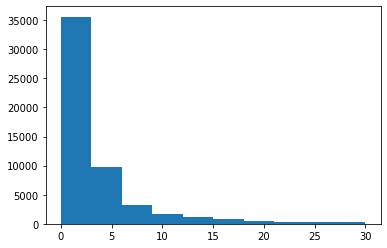

In [135]:
plot(adm_icu_p[['LOS']])
plt.hist(adm_icu_p[adm_icu_p['LOS']<=30]['LOS']);

# 1. Age & Gender

In [93]:
plot(adm_icu_p[['age']])
plot(adm_icu_p[['GENDER']])

GridBox(id='4663', ...)

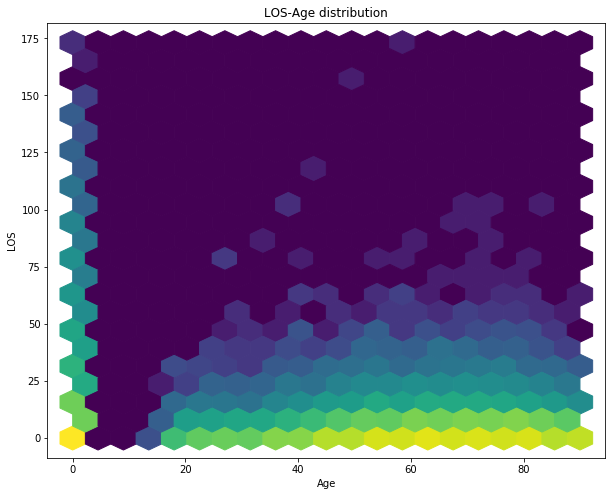

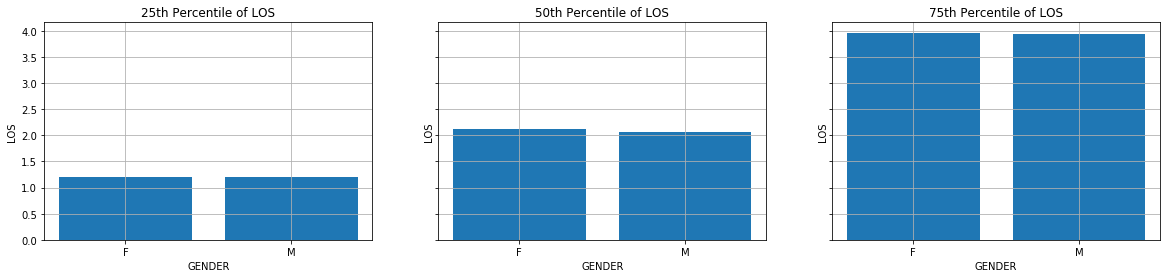

In [94]:
# Age - LOS
f1, ax1 = plt.subplots(figsize=(10, 8))
hb1 = plt.hexbin(adm_icu_p['age'], adm_icu_p['LOS'], gridsize=20, bins='log')
ax1.set(xlabel='Age', ylabel='LOS')
ax1.set_title('LOS-Age distribution');

# Gender(Adult) - LOS
adults = adm_icu_p[adm_icu_p['age']>=15]
p25 = adults.groupby('GENDER')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adults.groupby('GENDER')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adults.groupby('GENDER')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='GENDER', how='left')
dfcor = dfcor.merge(p75, on='GENDER', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='GENDER', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='GENDER', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='GENDER', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['GENDER'], dfcor['25TH_LOS'])
ax02.bar(dfcor['GENDER'], dfcor['50TH_LOS'])
ax03.bar(dfcor['GENDER'], dfcor['75TH_LOS']);

# 2. Admission Type

In [95]:
plot(adm_icu_p[['ADMISSION_TYPE']])

GridBox(id='4890', ...)

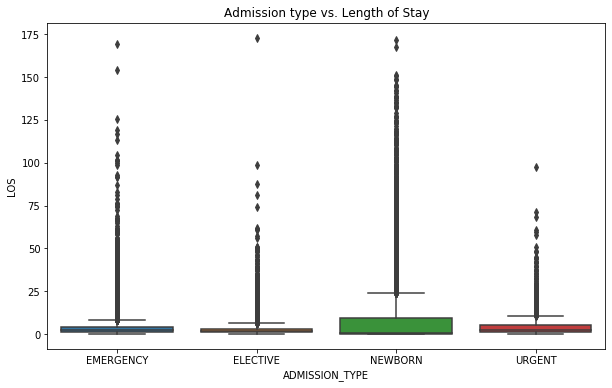

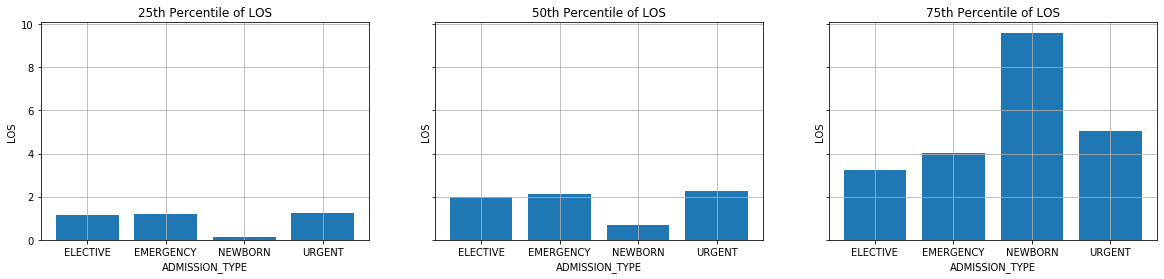

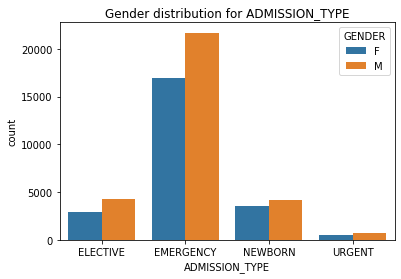

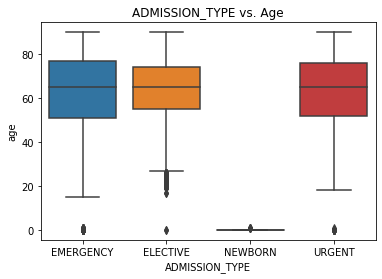

In [97]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='ADMISSION_TYPE', y='LOS', data=adm_icu_p)
ax.set_title('Admission type vs. Length of Stay')
fig.set_size_inches(10, 6, forward=True)
p25 = adm_icu_p.groupby('ADMISSION_TYPE')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p.groupby('ADMISSION_TYPE')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p.groupby('ADMISSION_TYPE')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='ADMISSION_TYPE', how='left')
dfcor = dfcor.merge(p75, on='ADMISSION_TYPE', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='ADMISSION_TYPE', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='ADMISSION_TYPE', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='ADMISSION_TYPE', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['ADMISSION_TYPE'], dfcor['25TH_LOS'])
ax02.bar(dfcor['ADMISSION_TYPE'], dfcor['50TH_LOS'])
ax03.bar(dfcor['ADMISSION_TYPE'], dfcor['75TH_LOS']);


# Adm_type - Gender
fig1, ax1 = plt.subplots()
data = adm_icu_p.groupby(['ADMISSION_TYPE', 'GENDER']).size().rename('count').reset_index()
ax1 = sns.barplot(x='ADMISSION_TYPE', y='count', hue='GENDER', data=data)
ax1.set_title('Gender distribution for ADMISSION_TYPE');
# Adm_type - Age
fig2, ax2 = plt.subplots()
ax2 = sns.boxplot(x='ADMISSION_TYPE', y='age', data=adm_icu_p)
ax2.set_title('ADMISSION_TYPE vs. Age')

plt.show();



# 3. ICU Type

In [98]:
# ICU first admission analysis
icu['INTIME'] = pd.to_datetime(icu['INTIME'])
icu_first = icu.groupby('SUBJECT_ID').agg({'INTIME':'min'})
icu_first = icu.merge(icu_first, on=['SUBJECT_ID', 'INTIME'])

# overall ICU type hist
plot(icu[['FIRST_CAREUNIT']])
# first adm ICU type hist
# plot(icu_first[['FIRST_CAREUNIT']])

GridBox(id='5123', ...)

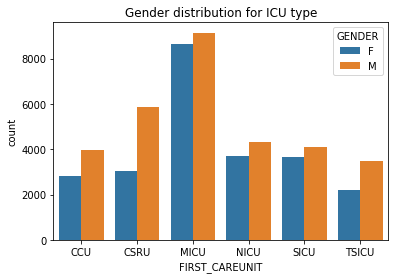

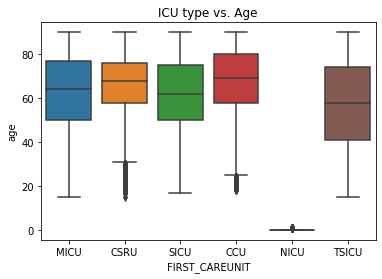

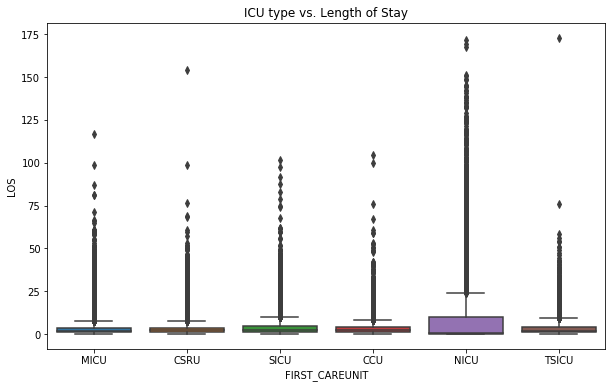

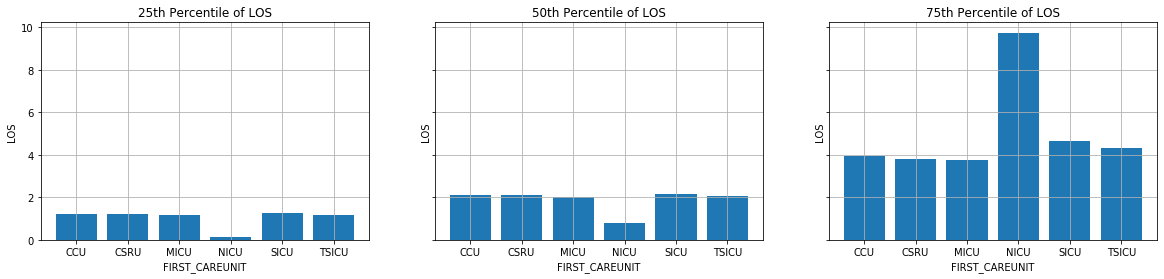

In [99]:
# icu_adm_p = icu_first.merge(admission_patient, on='SUBJECT_ID')

# ICU type vs Gender
fig1, ax1 = plt.subplots()
data = adm_icu_p.groupby(['FIRST_CAREUNIT', 'GENDER']).size().rename('count').reset_index()
ax1 = sns.barplot(x='FIRST_CAREUNIT', y='count', hue='GENDER', data=data)
ax1.set_title('Gender distribution for ICU type')
# ICU type vs age
fig2, ax2 = plt.subplots()
ax2 = sns.boxplot(x='FIRST_CAREUNIT', y='age', data=adm_icu_p)
ax2.set_title('ICU type vs. Age')
# ICU type vs LOS
fig3, ax3 = plt.subplots()
ax3 = sns.boxplot(x='FIRST_CAREUNIT', y='LOS', data=adm_icu_p)
ax3.set_title('ICU type vs. Length of Stay')
fig3.set_size_inches(10, 6, forward=True)

# icu_type = icu_adm_p.groupby('FIRST_CAREUNIT')['LOS']..quantile(0.25).reset_index(name='25TH_HOUSE_PRICE')
p25 = adm_icu_p.groupby('FIRST_CAREUNIT')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p.groupby('FIRST_CAREUNIT')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p.groupby('FIRST_CAREUNIT')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='FIRST_CAREUNIT', how='left')
dfcor = dfcor.merge(p75, on='FIRST_CAREUNIT', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='FIRST_CAREUNIT', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='FIRST_CAREUNIT', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='FIRST_CAREUNIT', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['FIRST_CAREUNIT'], dfcor['25TH_LOS'])
ax02.bar(dfcor['FIRST_CAREUNIT'], dfcor['50TH_LOS'])
ax03.bar(dfcor['FIRST_CAREUNIT'], dfcor['75TH_LOS']);

# # ICU type vs Mortality
# fig4, ax4 = plt.subplots()
# data2 = adm_icu_p.groupby(['FIRST_CAREUNIT', 'HOSPITAL_EXPIRE_FLAG']).size().rename('count').reset_index()
# ax4 = sns.barplot(x='FIRST_CAREUNIT', y='count', hue='HOSPITAL_EXPIRE_FLAG', data=data2)
# ax4.set_title('ICU type vs. Mortality')

plt.show();

# 4. Diagnosis

In [100]:
plot(adm_icu_p[['DIAGNOSIS']])

GridBox(id='5362', ...)

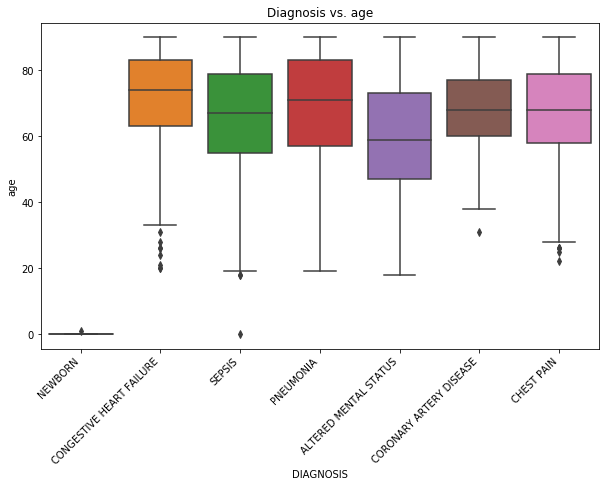

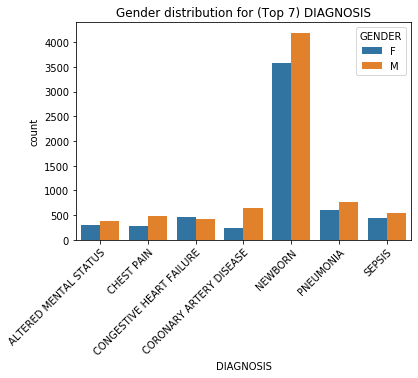

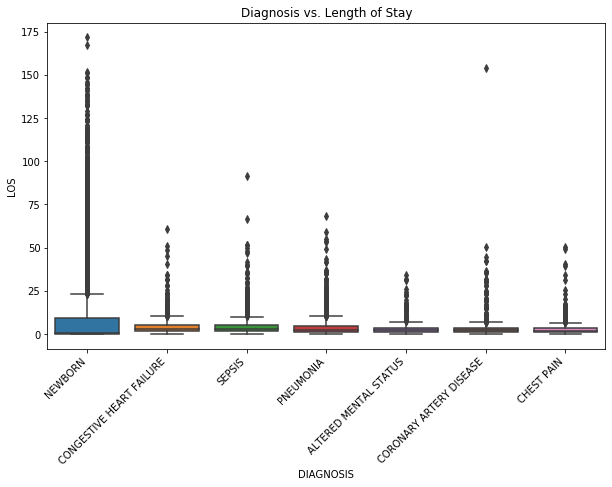

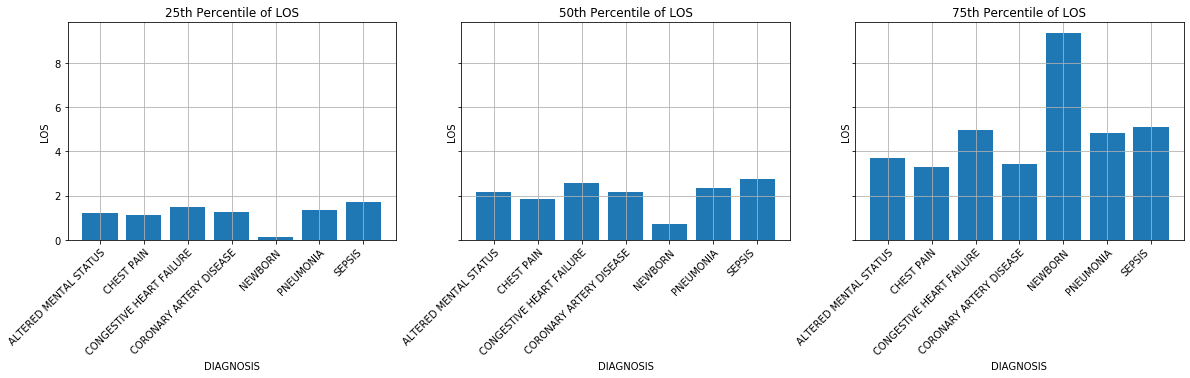

In [102]:
# Top 7
top_7 = ['NEWBORN', 'PNEUMONIA', 'SEPSIS', 'CONGESTIVE HEART FAILURE', 'CORONARY ARTERY DISEASE', 'CHEST PAIN', 'ALTERED MENTAL STATUS']
top_diag = adm_icu_p
top_diag['flag'] = top_diag['DIAGNOSIS'].apply(lambda x: 1 if (x in top_7) else 0)
top_diag = top_diag[top_diag['flag']==1]
# Diag - Age
fig1, ax1 = plt.subplots()
ax1 = sns.boxplot(x='DIAGNOSIS', y='age', data=top_diag)
ax1.set_title('Diagnosis vs. age')
fig1.set_size_inches(10, 6, forward=True)
ax1.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

# Diag - gender
fig2, ax2 = plt.subplots()
data = top_diag.groupby(['DIAGNOSIS', 'GENDER']).size().rename('count').reset_index()
ax2 = sns.barplot(x='DIAGNOSIS', y='count', hue='GENDER', data=data)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_title('Gender distribution for (Top 7) DIAGNOSIS');

# Diag - LOS
fig, ax = plt.subplots()
ax = sns.boxplot(x='DIAGNOSIS', y='LOS', data=top_diag)
ax.set_title('Diagnosis vs. Length of Stay')
fig.set_size_inches(10, 6, forward=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

p25 = top_diag.groupby('DIAGNOSIS')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = top_diag.groupby('DIAGNOSIS')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = top_diag.groupby('DIAGNOSIS')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='DIAGNOSIS', how='left')
dfcor = dfcor.merge(p75, on='DIAGNOSIS', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
plt.setp(ax01.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax02.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax03.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax01.set(xlabel='DIAGNOSIS', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='DIAGNOSIS', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='DIAGNOSIS', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['DIAGNOSIS'], dfcor['25TH_LOS'])
ax02.bar(dfcor['DIAGNOSIS'], dfcor['50TH_LOS'])
ax03.bar(dfcor['DIAGNOSIS'], dfcor['75TH_LOS'])

plt.show();

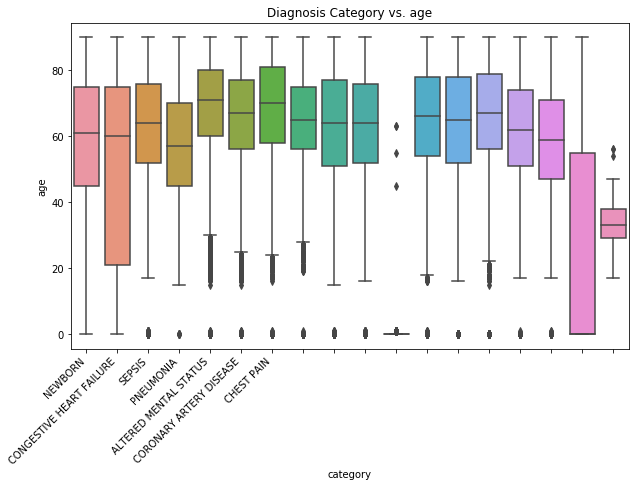

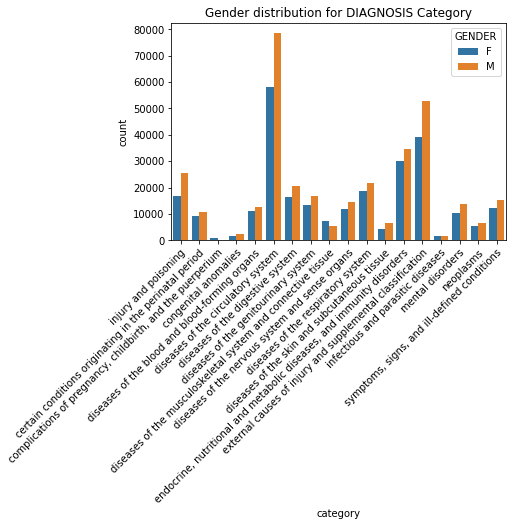

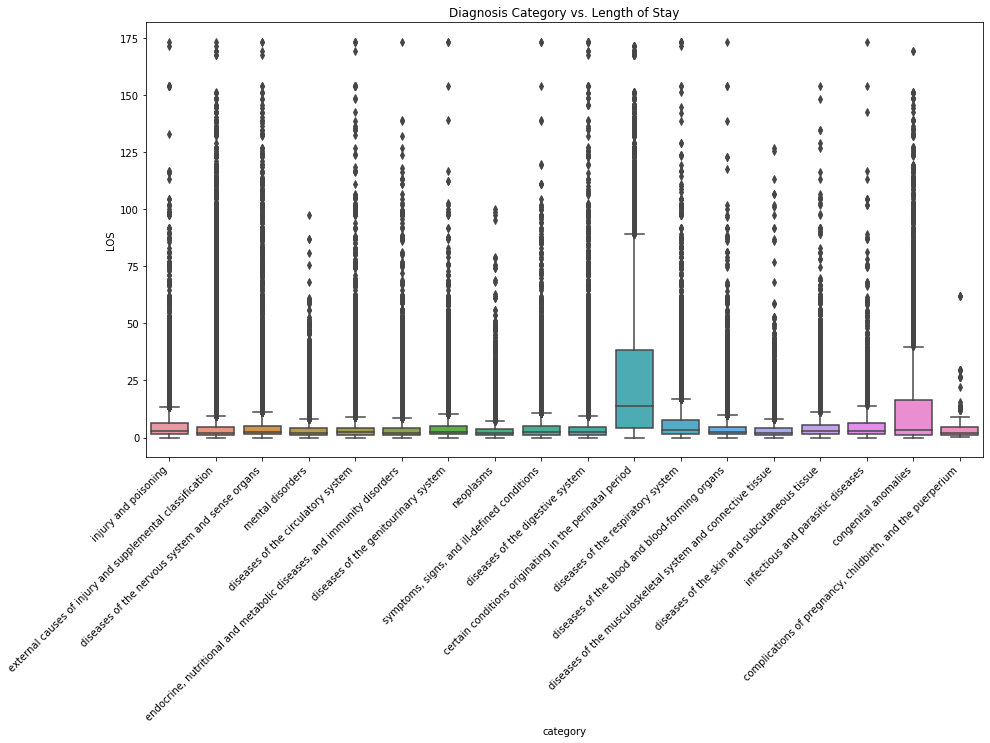

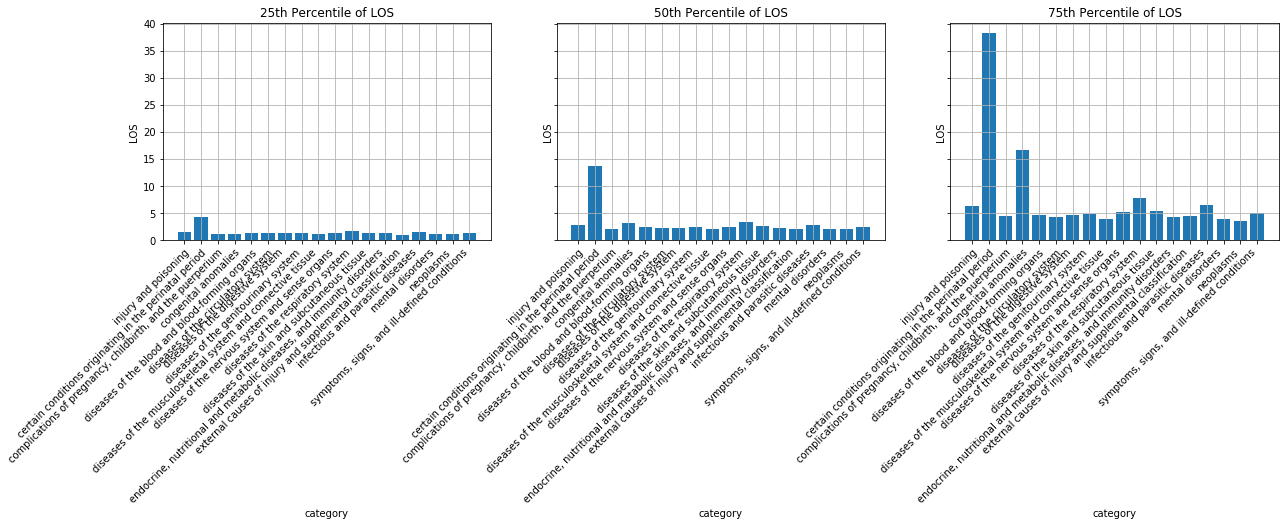

In [111]:
# Diag-Group
adm_icu_p_d = adm_icu_p.merge(diagnoses, on='HADM_ID')

# Diag Group - Age
fig1, ax1 = plt.subplots()
ax1 = sns.boxplot(x='category', y='age', data=adm_icu_p_d)
ax1.set_title('Diagnosis Category vs. age')
fig1.set_size_inches(10, 6, forward=True)
ax1.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

# Diag Group - gender
fig2, ax2 = plt.subplots()
data = adm_icu_p_d.groupby(['category', 'GENDER']).size().rename('count').reset_index()
ax2 = sns.barplot(x='category', y='count', hue='GENDER', data=data)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_title('Gender distribution for DIAGNOSIS Category');

# Diag Group - LOS
fig3, ax3 = plt.subplots()
ax3 = sns.boxplot(x='category', y='LOS', data=adm_icu_p_d)
ax3.set_title('Diagnosis Category vs. Length of Stay')
fig3.set_size_inches(15, 8, forward=True)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, horizontalalignment='right');

p25 = adm_icu_p_d.groupby('category')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = adm_icu_p_d.groupby('category')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = adm_icu_p_d.groupby('category')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='category', how='left')
dfcor = dfcor.merge(p75, on='category', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
ax01.grid()
ax02.grid()
ax03.grid()
plt.setp(ax01.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax02.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax03.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax01.set(xlabel='category', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='category', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='category', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['category'], dfcor['25TH_LOS'])
ax02.bar(dfcor['category'], dfcor['50TH_LOS'])
ax03.bar(dfcor['category'], dfcor['75TH_LOS'])

plt.show();

# 5. Service Type

In [115]:
# Service Type
service_icu = services.merge(adm_icu_p, on='HADM_ID')
plot(service_icu[['CURR_SERVICE']])


GridBox(id='6647', ...)

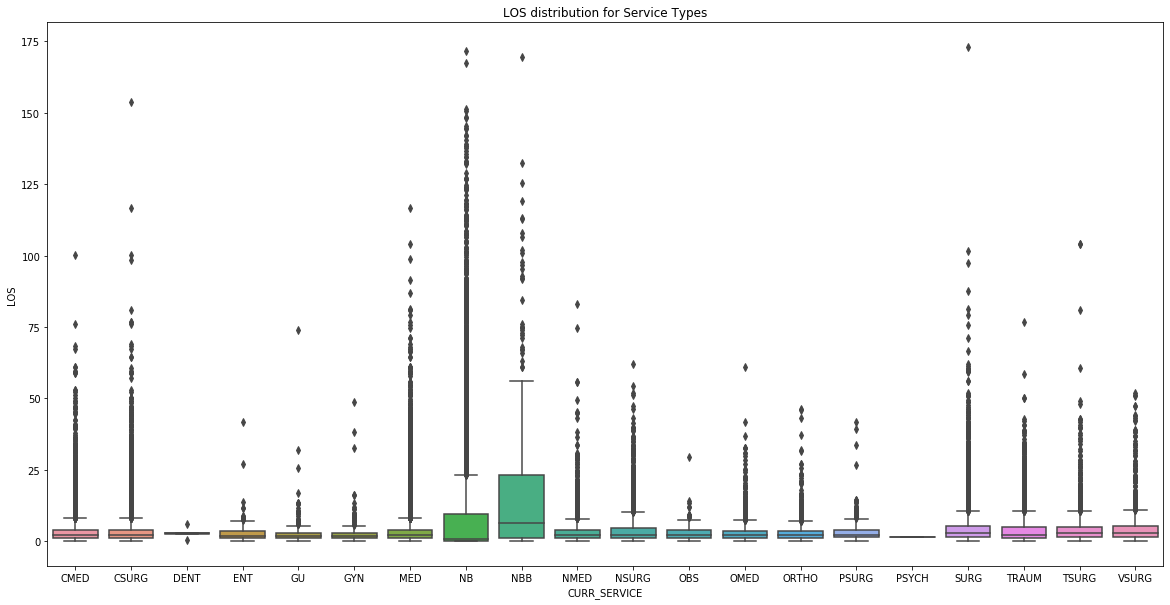

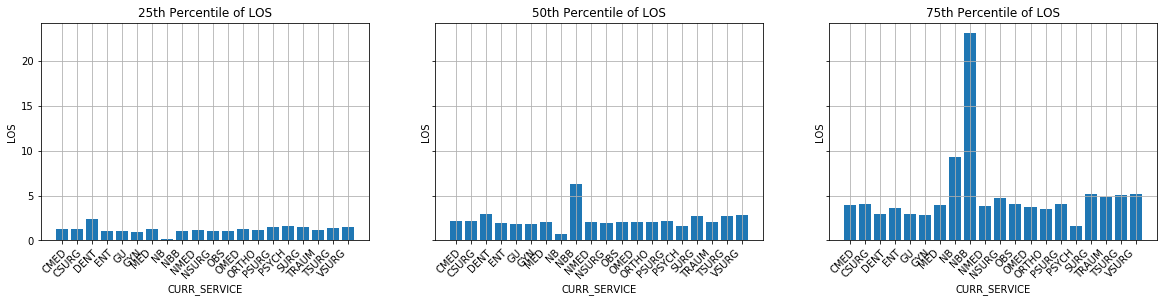

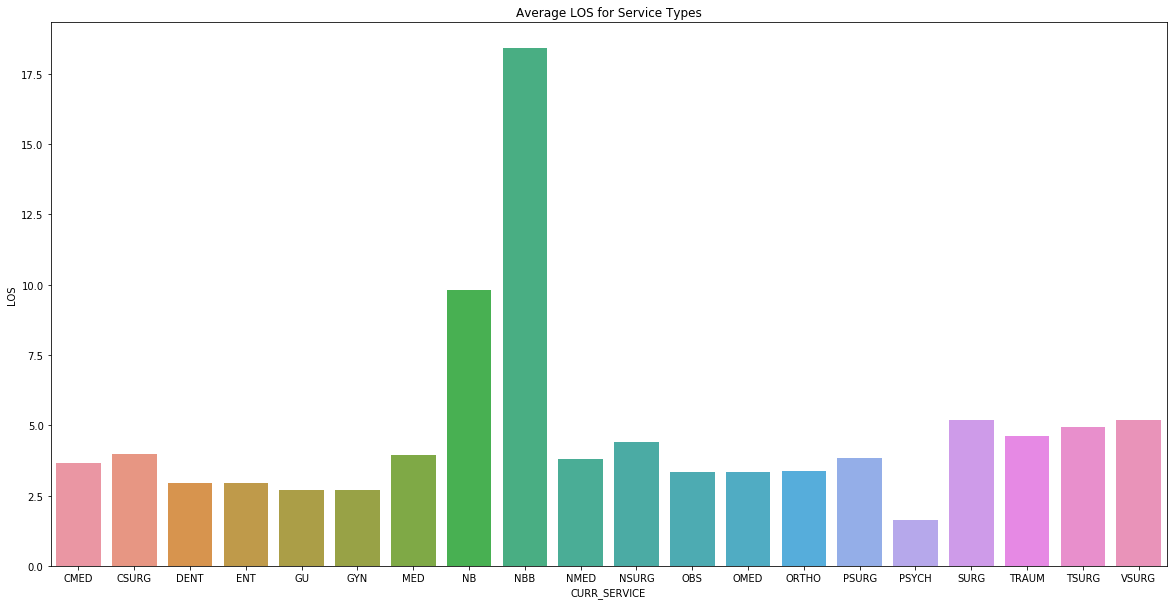

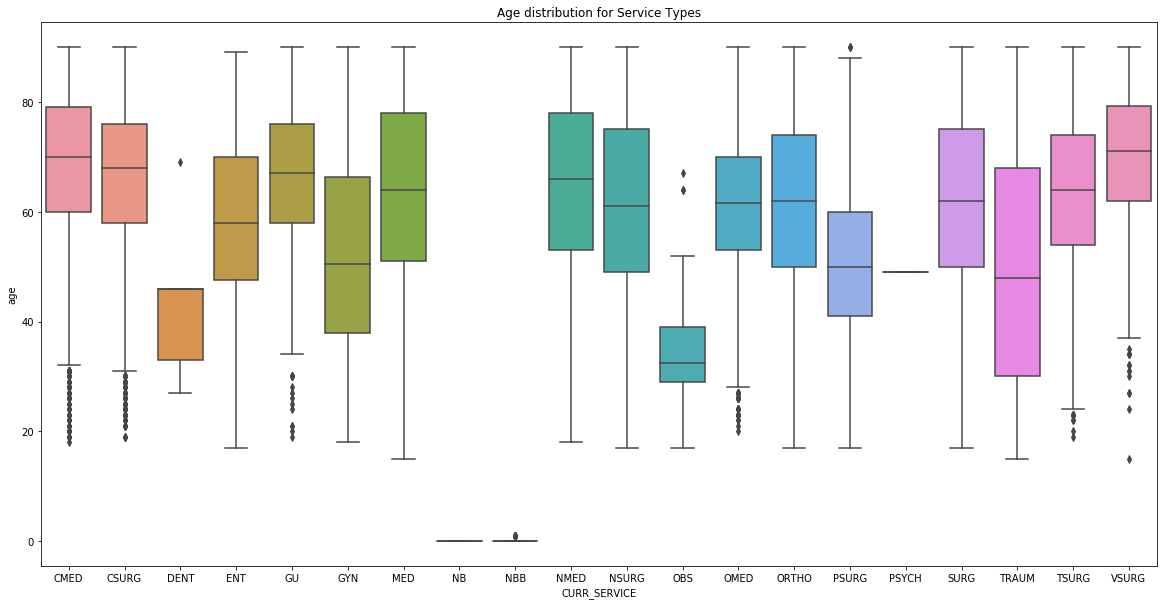

In [116]:
# Service - LOS
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1 = sns.boxplot(x="CURR_SERVICE", y="LOS", data=service_icu.sort_values(by='CURR_SERVICE'))
ax1.set_title('LOS distribution for Service Types');

p25 = service_icu.groupby('CURR_SERVICE')['LOS'].quantile(0.25).reset_index(name='25TH_LOS')
p50 = service_icu.groupby('CURR_SERVICE')['LOS'].quantile(0.5).reset_index(name='50TH_LOS')
p75 = service_icu.groupby('CURR_SERVICE')['LOS'].quantile(0.75).reset_index(name='75TH_LOS')
dfcor = p25.merge(p50, on='CURR_SERVICE', how='left')
dfcor = dfcor.merge(p75, on='CURR_SERVICE', how='left')
fig, (ax01, ax02, ax03) = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
plt.setp(ax01.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax02.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax03.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax01.grid()
ax02.grid()
ax03.grid()
ax01.set(xlabel='CURR_SERVICE', ylabel='LOS', title='25th Percentile of LOS')
ax02.set(xlabel='CURR_SERVICE', ylabel='LOS', title='50th Percentile of LOS')
ax03.set(xlabel='CURR_SERVICE', ylabel='LOS', title='75th Percentile of LOS')
ax01.bar(dfcor['CURR_SERVICE'], dfcor['25TH_LOS'])
ax02.bar(dfcor['CURR_SERVICE'], dfcor['50TH_LOS'])
ax03.bar(dfcor['CURR_SERVICE'], dfcor['75TH_LOS']);

f2, ax2 = plt.subplots(figsize=(20, 10))
serv_icu_g = service_icu.groupby('CURR_SERVICE')['LOS'].mean().reset_index()
ax2 = sns.barplot(x='CURR_SERVICE', y='LOS', data=serv_icu_g.sort_values(by='CURR_SERVICE'))
ax2.set_title('Average LOS for Service Types');

# Service - Age
# icu_p = icu.merge(patient, on='SUBJECT_ID')
# icu_p['age'] = calculate_age(icu_p, 'INTIME', 'DOB')
# icu_age = icu_p[['HADM_ID', 'age']]
# service_icu = service_icu.merge(icu_age, on='HADM_ID')
f3, ax3 = plt.subplots(figsize=(20, 10))
ax3 = sns.boxplot(x="CURR_SERVICE", y="age", data=service_icu.sort_values(by='CURR_SERVICE'))
ax3.set_title('Age distribution for Service Types')

plt.show();